# Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Loading the Dataset

In [2]:
df = pd.read_csv('AM_MAsterData.csv')

In [3]:
df.head()

,Author/Paper,Powder Material,Substrate Material,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
0,El Cheikh,316L,316L,0.53,180,1.5,300.0,0.47,0.56,NaN,0.839
1,El Cheikh,316L,316L,0.53,180,1.5,600.0,0.19,0.50,NaN,0.380
2,El Cheikh,316L,316L,0.53,180,1.5,900.0,0.15,0.43,NaN,0.349
3,El Cheikh,316L,316L,0.53,180,3.0,300.0,0.73,0.41,NaN,1.780
4,El Cheikh,316L,316L,0.53,180,3.0,600.0,0.39,0.38,NaN,1.026


In [4]:
df.describe()

,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
count,303.000000,387.000000,387.000000,387.000000,351.000000,351.000000,265.000000,315.000000
mean,1.973630,584.139535,9.967144,340.787080,0.451635,1.328989,84.665245,0.378279
std,1.397092,949.288049,10.738164,184.992889,0.465068,1.076509,54.084430,0.326047
min,0.530000,150.000000,1.500000,100.200000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,198.500000,2.880000,233.000000,0.180500,0.631000,25.000000,0.127500
50%,1.000000,276.000000,5.502000,300.000000,0.320000,1.162000,93.100000,0.322000
75%,3.200000,360.000000,12.000000,408.000000,0.600500,1.707000,130.000000,0.592500
max,6.000000,5700.000000,70.000000,1200.000000,3.270000,6.030000,168.000000,2.893000


In [5]:
df.columns

Index(['Author/Paper', 'Powder Material', 'Substrate Material',
       'Spot Size (mm)', 'Power (W)', 'Mass Flowrate (g/min)',
       'Travel Velocity (mm/min)', 'Height (mm)', 'Width (mm)',
       'Contact Angle (deg)', 'Aspect Ratio (H/W)'],
      dtype='object')

# Feature Engineering

## Dropping unnecessary columns

Dropping `Author/Paper` feature as not required

In [6]:
df.drop(['Author/Paper'], inplace = True, axis=1)

# Handling Null Values

In [7]:
df.shape

(387, 10)

In [8]:
print((df.isnull().sum() / len(df) * 100).round(2))

Powder Material              0.00
Substrate Material           0.00
Spot Size (mm)              21.71
Power (W)                    0.00
Mass Flowrate (g/min)        0.00
Travel Velocity (mm/min)     0.00
Height (mm)                  9.30
Width (mm)                   9.30
Contact Angle (deg)         31.52
Aspect Ratio (H/W)          18.60
dtype: float64


### Spot size and Contact Angle, Height and Width

- 21%, 31% are manageable for imputation

- `Spot Size`, `Contact Angle` are too important to remove from our EDA.

- Dropping these rows would lose 21% of your dataset

- `Height` and `Width` are also important features, they have outliers also and so cannot be imputed with mean/median. It is best to impute them with KNNImputer as well

We will use advanced imputation technique called as KNN imputer

In [9]:
df.describe()

,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
count,303.000000,387.000000,387.000000,387.000000,351.000000,351.000000,265.000000,315.000000
mean,1.973630,584.139535,9.967144,340.787080,0.451635,1.328989,84.665245,0.378279
std,1.397092,949.288049,10.738164,184.992889,0.465068,1.076509,54.084430,0.326047
min,0.530000,150.000000,1.500000,100.200000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,198.500000,2.880000,233.000000,0.180500,0.631000,25.000000,0.127500
50%,1.000000,276.000000,5.502000,300.000000,0.320000,1.162000,93.100000,0.322000
75%,3.200000,360.000000,12.000000,408.000000,0.600500,1.707000,130.000000,0.592500
max,6.000000,5700.000000,70.000000,1200.000000,3.270000,6.030000,168.000000,2.893000


In [10]:
from sklearn.impute import KNNImputer
# Use related features for better imputation
imputer = KNNImputer(n_neighbors=5)
# Select features that might be related to Spot Size
features_for_imputation = ['Spot Size (mm)', 'Contact Angle (deg)','Height (mm)','Width (mm)']
# Perform imputation
df[features_for_imputation] = imputer.fit_transform(df[features_for_imputation])

In [11]:
df.describe()

,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,315.000000
mean,2.187726,584.139535,9.967144,340.787080,0.494458,1.366023,86.488514,0.378279
std,1.328707,949.288049,10.738164,184.992889,0.473613,1.034030,50.381990,0.326047
min,0.530000,150.000000,1.500000,100.200000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,198.500000,2.880000,233.000000,0.195000,0.670000,41.100000,0.127500
50%,2.000000,276.000000,5.502000,300.000000,0.337000,1.340000,95.928000,0.322000
75%,3.200000,360.000000,12.000000,408.000000,0.690000,1.734000,128.200000,0.592500
max,6.000000,5700.000000,70.000000,1200.000000,3.270000,6.030000,168.000000,2.893000


Note: As we can see there are no major changes in statistics post imputing the values

In [12]:
print((df.isnull().sum() / len(df) * 100).round(2))

Powder Material              0.0
Substrate Material           0.0
Spot Size (mm)               0.0
Power (W)                    0.0
Mass Flowrate (g/min)        0.0
Travel Velocity (mm/min)     0.0
Height (mm)                  0.0
Width (mm)                   0.0
Contact Angle (deg)          0.0
Aspect Ratio (H/W)          18.6
dtype: float64


### Aspect Ratio
<b>Imputing target variables is generally not recommended because:</b>

- Can introduce bias in model training
- May lead to unreliable model performance
- Creates artificial relationships
- Makes model evaluation less reliable


<b>18% is significant but manageable loss of data</b>

- You'll still have 82% of data for training
- Better to have less but reliable data
- Maintains data integrity

In [13]:
df = df.dropna(subset=['Aspect Ratio (H/W)'])

In [14]:
print(df.shape)
print(print((df.isnull().sum() / len(df) * 100).round(2)))

(315, 10)
Powder Material             0.0
Substrate Material          0.0
Spot Size (mm)              0.0
Power (W)                   0.0
Mass Flowrate (g/min)       0.0
Travel Velocity (mm/min)    0.0
Height (mm)                 0.0
Width (mm)                  0.0
Contact Angle (deg)         0.0
Aspect Ratio (H/W)          0.0
dtype: float64
None


# Outliers
<b>Note: We have `intentional outliers` in the dataset and so removing them is not a good idea. 

# Transformations

For handling skewness in the data, we need to perform box-cox transformation

 `Spot size`, `Power`, `Mass FlowRate`, `Travel Velocity`, `Height`, `Width` are positively skewed as per our EDA, and so we will have to use a box-cox transformation

In [ ]:
def apply_box_cox_transformation(df_train, skewed_features):
    """
    Apply Box-Cox transformation to positively skewed features
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe
    skewed_features : list
        List of features to transform
    
    Returns:
    --------
    df_transformed : pandas DataFrame
        DataFrame with transformed features
    power_transformer : PowerTransformer
        Fitted transformer object
    """
    # Create copy of dataframe
    df_transformed = df_train.copy()
    
    # Initialize transformer
    power_transformer = PowerTransformer(method='box-cox', standardize=False)
    
    # Function to plot distribution before and after transformation
    def plot_distribution(data_original, data_transformed, feature):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Original distribution
        sns.histplot(data_original, ax=ax1, kde=True)
        ax1.set_title(f'Original Distribution of {feature}')
        ax1.set_xlabel(feature)
        
        # Transformed distribution
        sns.histplot(data_transformed, ax=ax2, kde=True)
        ax2.set_title(f'Transformed Distribution of {feature}')
        ax2.set_xlabel(f'{feature} (Box-Cox transformed)')
        
        plt.tight_layout()
        plt.show()
    
    # Print skewness before and after transformation
    print("\nSkewness Before and After Box-Cox Transformation:")
    print("-" * 50)
    print(f"{'Feature':<20} {'Before':>10} {'After':>10}")
    print("-" * 50)
    
    # Transform features
    features_to_transform = []
    for feature in skewed_features:
        # Check if feature has all positive values
        if df[feature].min() <= 0:
            print(f"\nWarning: {feature} has zero or negative values.")
            print("Adding minimum value to make all values positive...")
            shift_value = abs(df[feature].min()) + 1
            df_transformed[feature] = df[feature] + shift_value
        
        features_to_transform.append(feature)
    
    # Fit and transform
    transformed_data_train = power_transformer.fit_transform(df_transformed[features_to_transform])
    
    # Update transformed features in dataframe
    for i, feature in enumerate(features_to_transform):
        # Store original data
        original_data = df[feature].copy()
        
        # Update transformed data
        df_transformed[feature] = transformed_data_train[:, i]
        
        # Calculate skewness
        skew_before = stats.skew(original_data)
        skew_after = stats.skew(df_transformed[feature])
        
        # Print skewness values
        print(f"{feature:<20} {skew_before:>10.3f} {skew_after:>10.3f}")
        
        # Plot distribution
        plot_distribution(original_data, df_transformed[feature], feature)
    
    return df_transformed, power_transformer



Skewness Before and After Box-Cox Transformation:
--------------------------------------------------
Feature                  Before      After
--------------------------------------------------

Adding minimum value to make all values positive...

Adding minimum value to make all values positive...
Spot Size (mm)            1.026      0.063


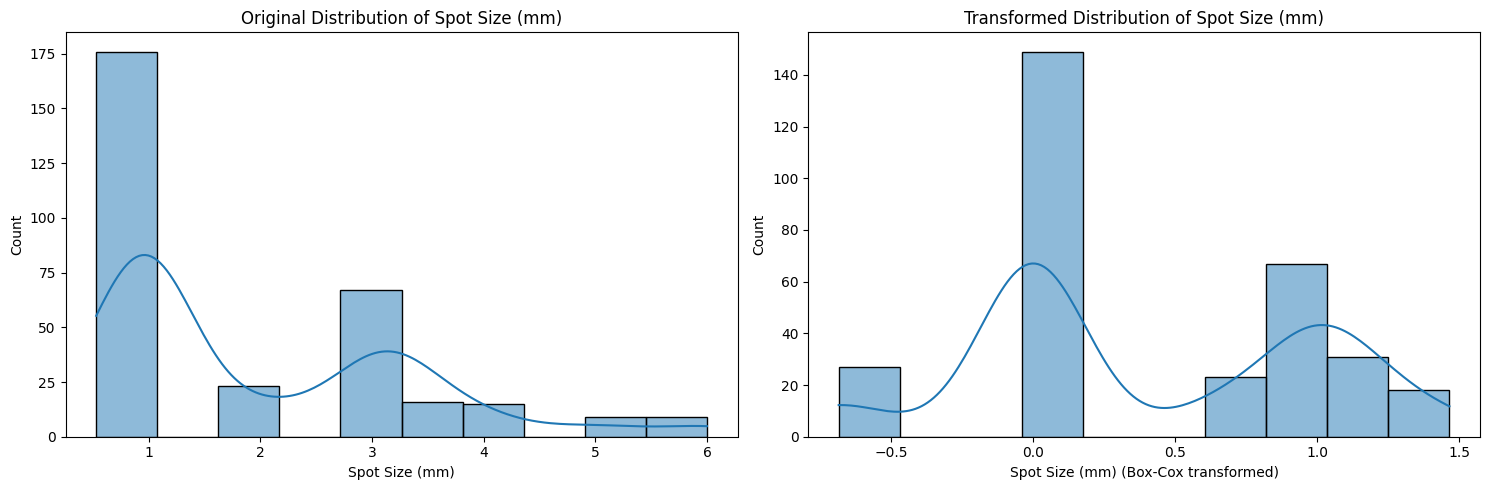

Power (W)                 4.473      0.301


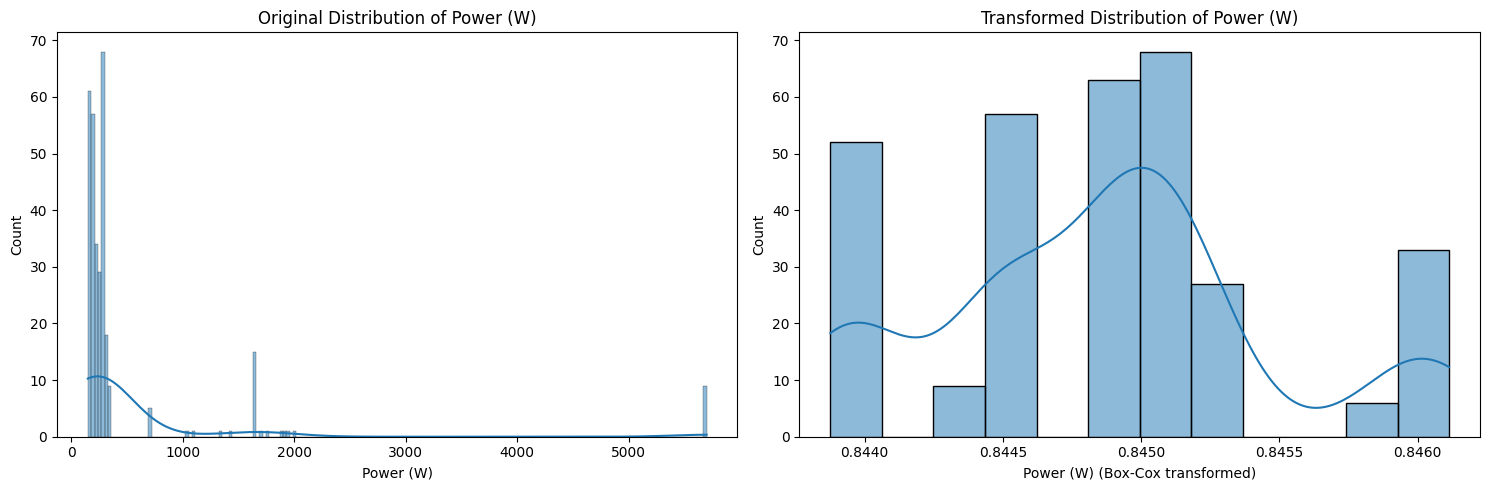

Mass Flowrate (g/min)      2.595      0.143


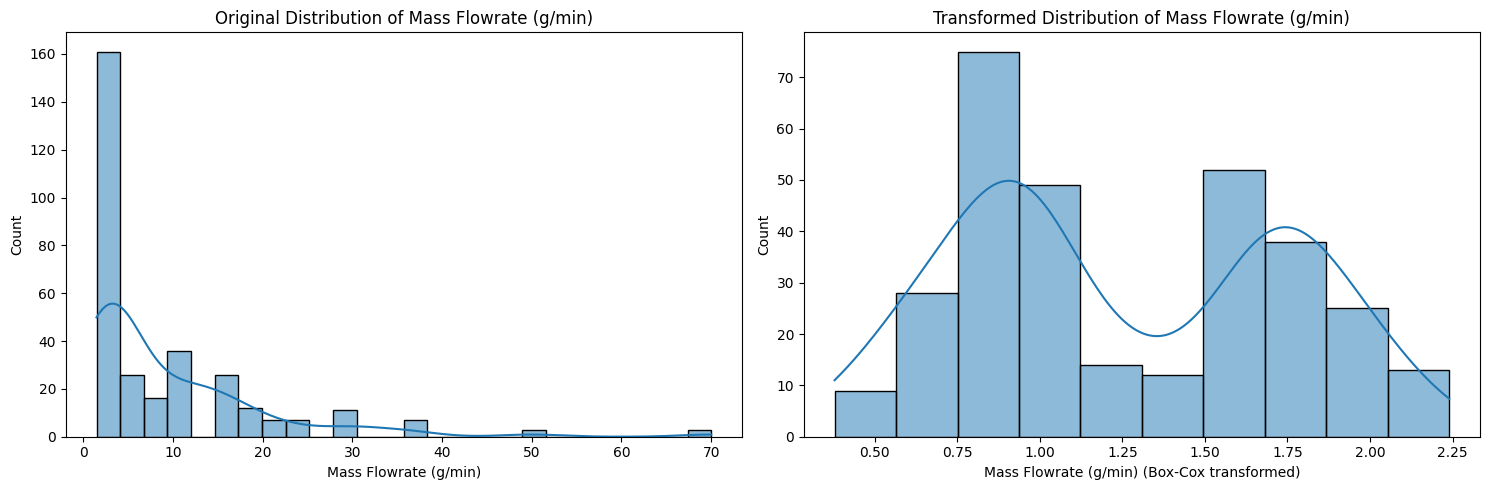

Travel Velocity (mm/min)      1.604      0.006


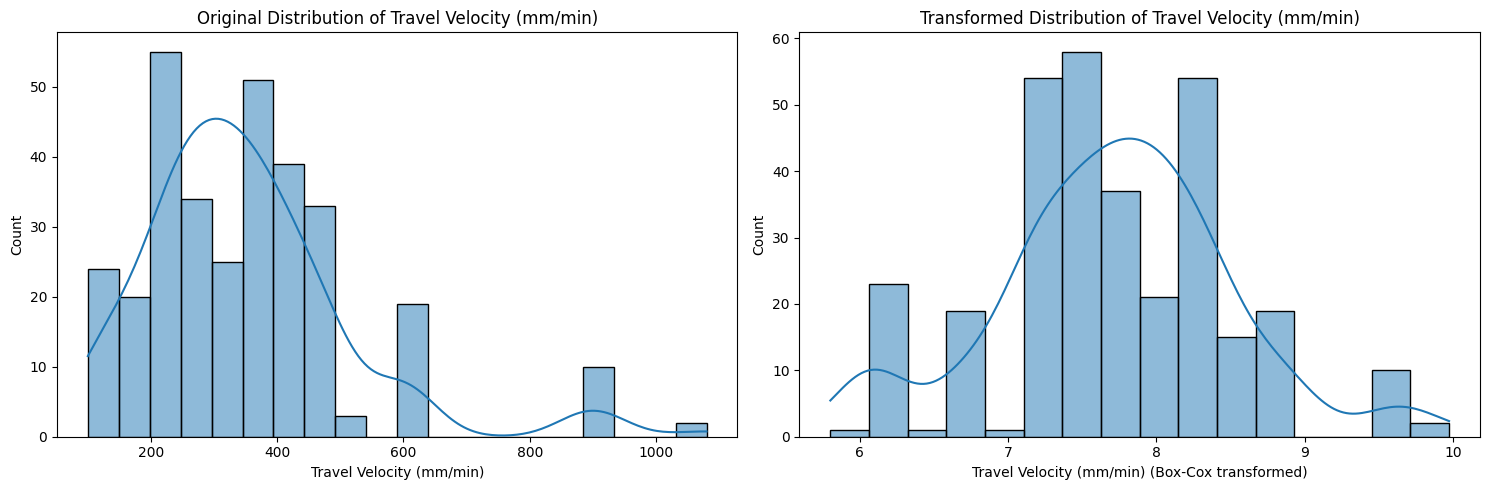

Height (mm)               3.325      0.058


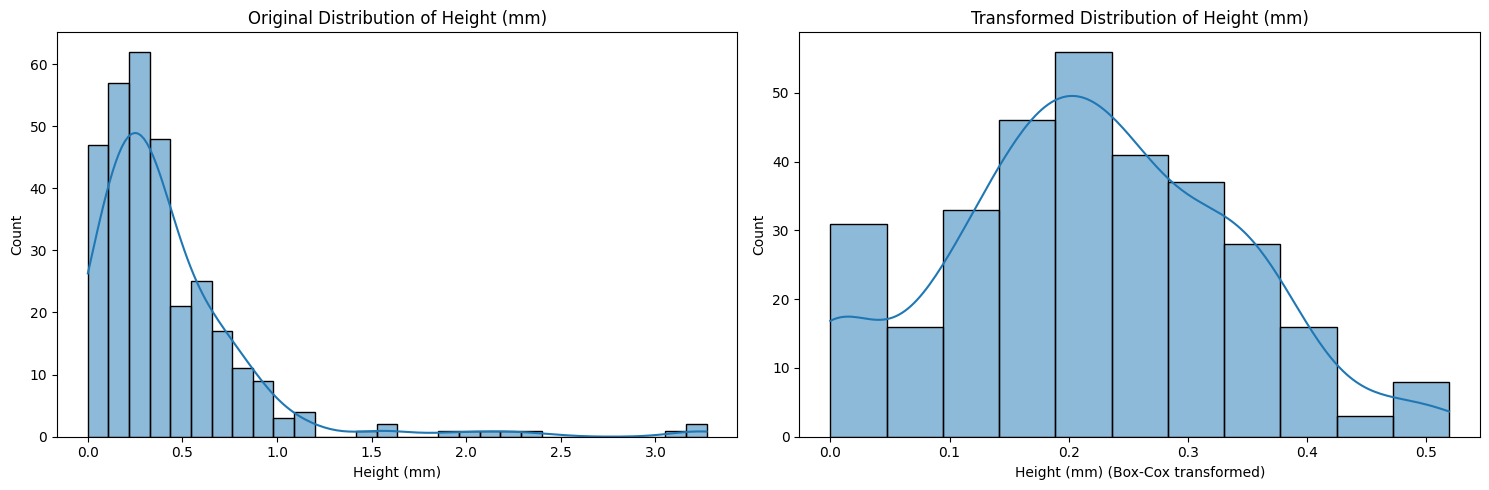

Width (mm)                1.807      0.003


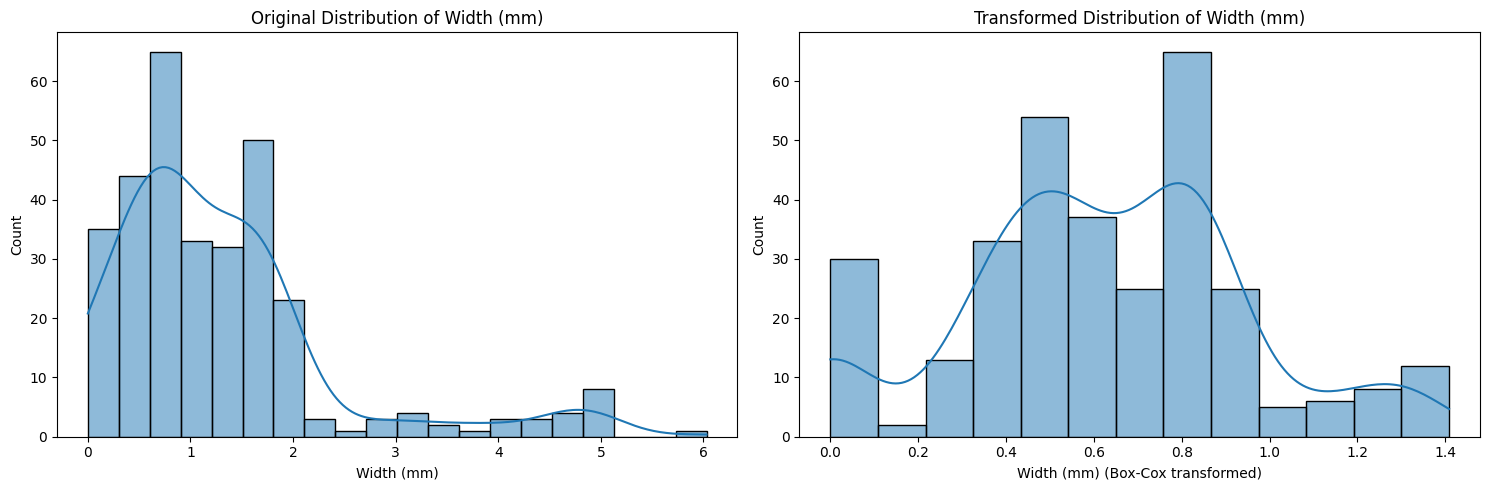

In [16]:
skewed_features = [
    'Spot Size (mm)',
    'Power (W)',
    'Mass Flowrate (g/min)',
    'Travel Velocity (mm/min)',
    'Height (mm)',
    'Width (mm)'
]

df_transformed, transformer = apply_box_cox_transformation(df, skewed_features)

As we can see, we have eliminated the skewness in the features

In [17]:
df_transformed.head()

,Powder Material,Substrate Material,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
0,316L,316L,-0.684235,0.844316,0.378607,7.607733,0.278752,0.411448,111.710,0.839
1,316L,316L,-0.684235,0.844316,0.378607,8.851312,0.149582,0.377707,69.100,0.380
2,316L,316L,-0.684235,0.844316,0.378607,9.618297,0.123722,0.335955,76.476,0.349
3,316L,316L,-0.684235,0.844316,0.915810,7.607733,0.349920,0.323514,123.154,1.780
4,316L,316L,-0.684235,0.844316,0.915810,8.851312,0.249129,0.304398,112.642,1.026


# Splitting the data into X and y

In [18]:
# Separate features and target

X = df_transformed.drop('Aspect Ratio (H/W)', axis=1)
y = df_transformed['Aspect Ratio (H/W)']

# Feature Selection Using Mutual Information

In [19]:
def select_features(X, y, threshold='mean'):
    """
    Select features using Mutual Information
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe
    target : str
        Target variable name
    threshold : str or float
        'mean' for mean MI score as threshold, or float value
    
    Returns:
    --------
    selected_features : list
        List of selected feature names
    """
    
    # Get numerical features
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[numeric_features])
    
    # Calculate mutual information scores
    mi_scores = mutual_info_regression(X_scaled, y)
    
    # Create a dataframe of features and their MI scores
    feature_importance = pd.DataFrame({
        'Feature': numeric_features,
        'MI_Score': mi_scores
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('MI_Score', ascending=False)
    
    # Determine threshold
    if threshold == 'mean':
        threshold_value = feature_importance['MI_Score'].mean()
    else:
        threshold_value = threshold
    
    # Select features above threshold
    selected_features = feature_importance[feature_importance['MI_Score'] > threshold_value]['Feature'].tolist()
    
    # Print results
    print("\nFeature Selection Results:")
    print("-" * 50)
    print("\nAll Features Ranked by Importance:")
    print(feature_importance.to_string(index=False))
    
    print(f"\nThreshold value: {threshold_value:.4f}")
    print(f"Number of selected features: {len(selected_features)}")
    print("\nSelected Features:")
    for feature in selected_features:
        score = feature_importance[feature_importance['Feature'] == feature]['MI_Score'].values[0]
        print(f"{feature}: {score:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance, x='MI_Score', y='Feature')
    plt.axvline(x=threshold_value, color='r', linestyle='--', 
                label=f'Threshold: {threshold_value:.4f}')
    plt.title('Feature Importance (Mutual Information)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print("\nFeature Selection Insights:")
    print("-" * 50)
    
    # Check for correlations among selected features
    high_corr_pairs = []
    for i in range(len(selected_features)):
        for j in range(i+1, len(selected_features)):
            corr = abs(df[selected_features[i]].corr(df[selected_features[j]]))
            if corr > 0.7:  # Threshold for high correlation
                high_corr_pairs.append((selected_features[i], selected_features[j], corr))
    
    if high_corr_pairs:
        print("\nHighly Correlated Feature Pairs (>0.7):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"{feat1} - {feat2}: {corr:.3f}")
        print("\nConsider removing one feature from each highly correlated pair")
    else:
        print("\nNo highly correlated pairs among selected features")
    
    return selected_features, feature_importance



Feature Selection Results:
--------------------------------------------------

All Features Ranked by Importance:
                 Feature  MI_Score
     Contact Angle (deg)  1.377775
             Height (mm)  0.916139
   Mass Flowrate (g/min)  0.800134
          Spot Size (mm)  0.776438
              Width (mm)  0.726259
Travel Velocity (mm/min)  0.612910
               Power (W)  0.501813

Threshold value: 0.6000
Number of selected features: 6

Selected Features:
Contact Angle (deg): 1.3778
Height (mm): 0.9161
Mass Flowrate (g/min): 0.8001
Spot Size (mm): 0.7764
Width (mm): 0.7263
Travel Velocity (mm/min): 0.6129


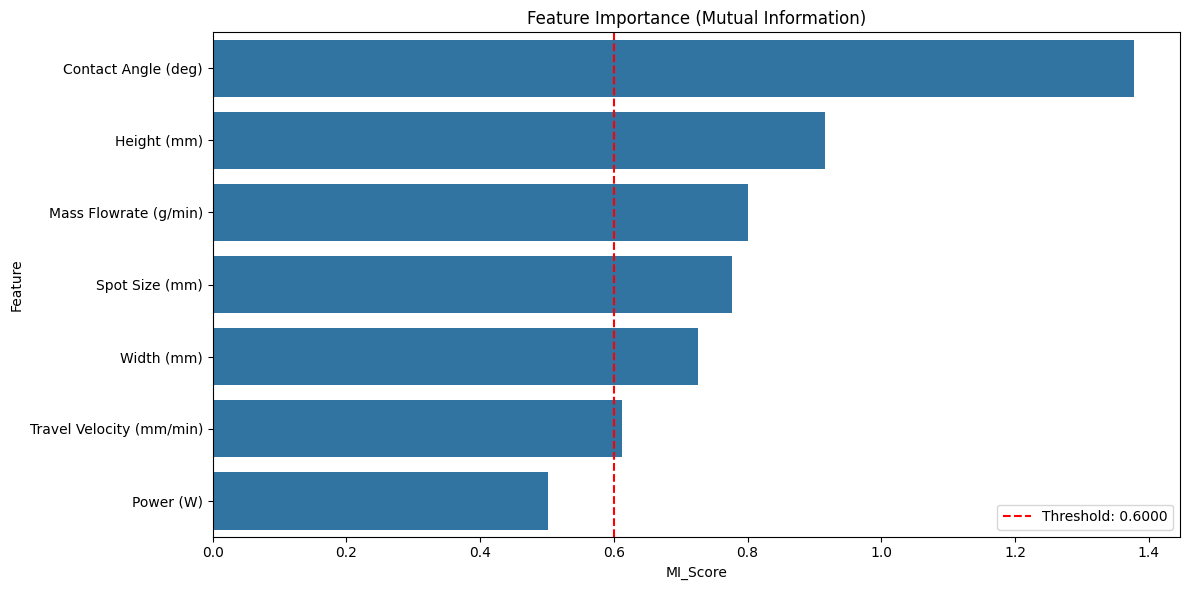


Feature Selection Insights:
--------------------------------------------------

Highly Correlated Feature Pairs (>0.7):
Spot Size (mm) - Width (mm): 0.891

Consider removing one feature from each highly correlated pair


In [20]:
# Get selected features
selected_features, importance = select_features(X,y,threshold=0.6)

In [21]:
selected_features

['Contact Angle (deg)',
 'Height (mm)',
 'Mass Flowrate (g/min)',
 'Spot Size (mm)',
 'Width (mm)',
 'Travel Velocity (mm/min)']

- We have reomved the features having less importances than 0.6
- Also, in our EDA, we found out that there is multi-collinearity among `Spot-size` and `Width`
Let us do the multi-collinearity step again

### Multi-Collinearity Check after Feature Selection

In [22]:
# Create new dataframe with selected features
df_selected = df_transformed[selected_features + ['Aspect Ratio (H/W)', 'Powder Material','Substrate Material']]
X = df_selected.drop('Aspect Ratio (H/W)', axis=1)
y = df_selected['Aspect Ratio (H/W)']

X.head()

,Contact Angle (deg),Height (mm),Mass Flowrate (g/min),Spot Size (mm),Width (mm),Travel Velocity (mm/min),Powder Material,Substrate Material
0,111.710,0.278752,0.378607,-0.684235,0.411448,7.607733,316L,316L
1,69.100,0.149582,0.378607,-0.684235,0.377707,8.851312,316L,316L
2,76.476,0.123722,0.378607,-0.684235,0.335955,9.618297,316L,316L
3,123.154,0.349920,0.915810,-0.684235,0.323514,7.607733,316L,316L
4,112.642,0.249129,0.915810,-0.684235,0.304398,8.851312,316L,316L


In [23]:
def analyze_multicollinearity(df, target='Aspect Ratio (H/W)', vif_threshold=5, corr_threshold=0.7):
    """
    Analyze multicollinearity among independent features using VIF and correlation matrix
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    target (str): Name of target variable
    vif_threshold (float): Threshold for VIF values (default=5)
    corr_threshold (float): Threshold for correlation values (default=0.7)
    """
    
    # Get independent numerical features
    independent_features = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
                          if col != target]
    
    # Create clean dataset for analysis
    df_clean = df[independent_features].copy()
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()
    
    print("1. VIF Analysis:")
    print("-" * 50)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = independent_features
    vif_data["VIF"] = [variance_inflation_factor(df_clean[independent_features].values, i)
                       for i in range(len(independent_features))]
    
    # Sort by VIF value
    vif_data = vif_data.sort_values('VIF', ascending=False)
    print("\nVIF Values:")
    print(vif_data)
    
    print("\nFeatures with high VIF (>", vif_threshold, "):")
    print(vif_data[vif_data['VIF'] > vif_threshold])
    
    # Correlation Analysis
    print("\n2. Correlation Analysis:")
    print("-" * 50)
    
    # Calculate correlation matrix
    correlation_matrix = df_clean[independent_features].corr()
    
    # Find highly correlated feature pairs
    high_correlation = np.where(np.abs(correlation_matrix) > corr_threshold)
    high_correlation = [(correlation_matrix.index[x], correlation_matrix.columns[y], 
                        correlation_matrix.iloc[x, y])
                       for x, y in zip(*high_correlation) 
                       if x != y and x < y]  # Remove diagonal and duplicate pairs
    
    print("\nHighly correlated feature pairs (correlation >", corr_threshold, "):")
    if high_correlation:
        for feat1, feat2, corr in high_correlation:
            print(f"{feat1} - {feat2}: {corr:.3f}")
    else:
        print("No highly correlated pairs found.")
    

    
    
    # Recommendations based on analysis
    print("\n3. Recommendations:")
    print("-" * 50)
    
    high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()
    
    if high_vif_features or high_correlation:
        print("\nConsider addressing multicollinearity by:")
        if high_vif_features:
            print("\nBased on VIF analysis:")
            for feature in high_vif_features:
                print(f"- Investigating feature: {feature} (VIF: {vif_data[vif_data['Feature']==feature]['VIF'].values[0]:.2f})")
        
        if high_correlation:
            print("\nBased on correlation analysis:")
            for feat1, feat2, corr in high_correlation:
                print(f"- Investigating relationship between {feat1} and {feat2} (correlation: {corr:.3f})")
        
        print("\nPossible solutions:")
        print("1. Feature selection: Remove one feature from each highly correlated pair")
        print("2. Feature combination: Create new features by combining correlated features")
        print("3. Principal Component Analysis (PCA)")
        print("4. Regular or elastic net regularization in modeling")
    else:
        print("No significant multicollinearity detected.")
    
    return {
        'vif_data': vif_data,
        'correlation_matrix': correlation_matrix,
        'high_correlation_pairs': high_correlation
    }

In [24]:
analyze_multicollinearity(df_selected)

1. VIF Analysis:
--------------------------------------------------

VIF Values:
                    Feature        VIF
4                Width (mm)  35.820437
2     Mass Flowrate (g/min)  18.518056
5  Travel Velocity (mm/min)  13.417231
1               Height (mm)  12.926622
3            Spot Size (mm)   9.465563
0       Contact Angle (deg)   4.525466

Features with high VIF (> 5 ):
                    Feature        VIF
4                Width (mm)  35.820437
2     Mass Flowrate (g/min)  18.518056
5  Travel Velocity (mm/min)  13.417231
1               Height (mm)  12.926622
3            Spot Size (mm)   9.465563

2. Correlation Analysis:
--------------------------------------------------

Highly correlated feature pairs (correlation > 0.7 ):
Mass Flowrate (g/min) - Spot Size (mm): 0.808
Spot Size (mm) - Width (mm): 0.786

3. Recommendations:
--------------------------------------------------

Consider addressing multicollinearity by:

Based on VIF analysis:
- Investigating feature: Wid

{'vif_data':                     Feature        VIF
 4                Width (mm)  35.820437
 2     Mass Flowrate (g/min)  18.518056
 5  Travel Velocity (mm/min)  13.417231
 1               Height (mm)  12.926622
 3            Spot Size (mm)   9.465563
 0       Contact Angle (deg)   4.525466,
 'correlation_matrix':                           Contact Angle (deg)  Height (mm)  \
 Contact Angle (deg)                  1.000000     0.419634   
 Height (mm)                          0.419634     1.000000   
 Mass Flowrate (g/min)                0.042247     0.158584   
 Spot Size (mm)                      -0.066745     0.120971   
 Width (mm)                           0.152955     0.582038   
 Travel Velocity (mm/min)            -0.312942    -0.033594   
 
                           Mass Flowrate (g/min)  Spot Size (mm)  Width (mm)  \
 Contact Angle (deg)                    0.042247       -0.066745    0.152955   
 Height (mm)                            0.158584        0.120971    0.582038   
 M

- We have multi-collinearity between `Width` - `Spot-size`, `Mass-FlowRate` - `Spot-size`. But through `EDA` and `Feature Importances` steps, we found out that they are significant features
- Either we can remove the feature with less MI

OR

- We can combine `Width`- `Spot-size` features and form a new feature using `product` or `ratio`. We will use ratio in this case

In [25]:
# Create a new feature that combines both
# Add small constant to Width to avoid division by zero
epsilon = 1e-10
    
df_selected['Size_Width_Ratio'] = df_selected['Spot Size (mm)'] / (df_selected['Width (mm)'] + epsilon)
df_selected['Size_Width_Ratio'] = df_selected['Spot Size (mm)'] / (df_selected['Width (mm)'] + epsilon)

# Drop original features
df_selected = df_selected.drop(['Spot Size (mm)', 'Width (mm)'], axis=1)

df_selected.head()

,Contact Angle (deg),Height (mm),Mass Flowrate (g/min),Travel Velocity (mm/min),Aspect Ratio (H/W),Powder Material,Substrate Material,Size_Width_Ratio
0,111.710,0.278752,0.378607,7.607733,0.839,316L,316L,-1.662993
1,69.100,0.149582,0.378607,8.851312,0.380,316L,316L,-1.811552
2,76.476,0.123722,0.378607,9.618297,0.349,316L,316L,-2.036690
3,123.154,0.349920,0.915810,7.607733,1.780,316L,316L,-2.115009
4,112.642,0.249129,0.915810,8.851312,1.026,316L,316L,-2.247828


## Handling Categorical Features

- Through EDA, we know that `Powder Material` and `Substrate Matrial` have imbalanced values

- We can try looking if the material properties of similar to form clusters

In [26]:
## Powder Material

# Create dictionary for powder material groups
material_groups = {
    'Nickel_based': ['Inconel 625', 'NiCr', 'NiCrAlY'],
    'Steel_based': ['316L', 'PH13-8'],
    'Cobalt_based': ['Cobalt', 'Colmonoy', 'WC-12Co'],
    'Titanium_based': ['Ti-6Al-4V'],
    'Copper_based': ['CuNiCo']
}

# Create dictionary for substrate material groups
substrate_groups = {
    'Steel_based': ['316L', 'Stainless Steel', 'Steel'],  # All steel variants
    'Nickel_based': ['Inconel 738'],  # Nickel superalloy
    'Titanium_based': ['Ti-6Al-4V']   # Titanium alloy
}

# Function to map material to group
def map_powder_material_to_group(material):
    for group, materials in material_groups.items():
        if material in materials:
            return group
    return 'Other'  # For any materials not in our groups

def map_substrate_material_to_group(material):
    for group, materials in substrate_groups.items():
        if material in materials:
            return group
    return 'Other'  # For any materials not in our groups

# Apply grouping
df_selected['Powder_Material_Group'] = df_selected['Powder Material'].map(lambda x: map_powder_material_to_group(x))
df_selected['Substrate_Material_Group'] = df_selected['Substrate Material'].map(lambda x: map_substrate_material_to_group(x))




Distribution of Powder Material Groups:
Powder_Material_Group
Steel_based       170
Cobalt_based       60
Nickel_based       54
Titanium_based     22
Copper_based        9
Name: count, dtype: int64


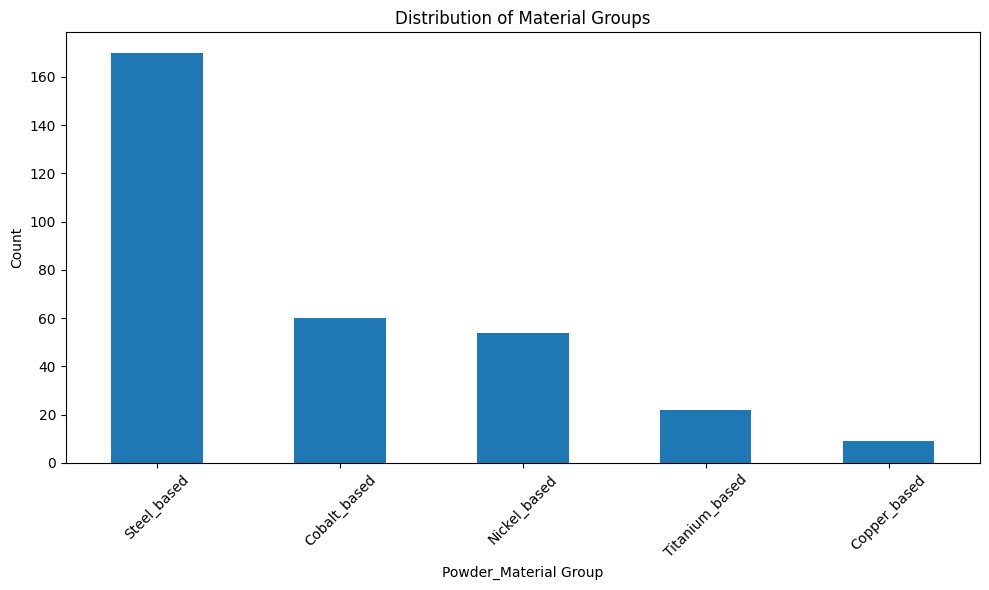


Distribution of Substrate Material Groups:
Substrate_Material_Group
Steel_based       245
Nickel_based       48
Titanium_based     22
Name: count, dtype: int64


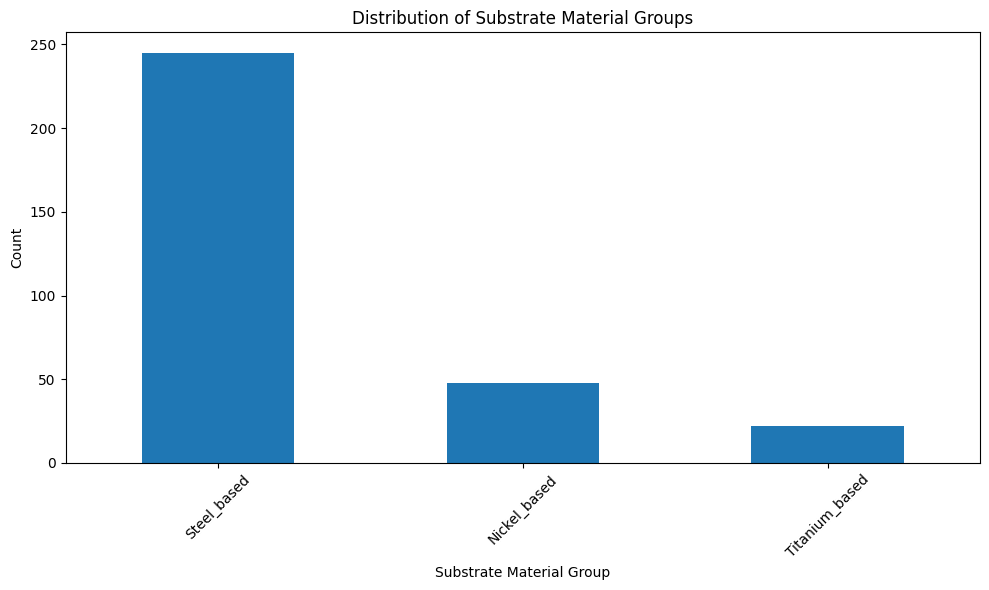

In [27]:
# Check distribution of groups

#Powder Material
print("\nDistribution of Powder Material Groups:")
print(df_selected['Powder_Material_Group'].value_counts())

# Visualize distribution
plt.figure(figsize=(10, 6))
df_selected['Powder_Material_Group'].value_counts().plot(kind='bar')
plt.title('Distribution of Material Groups')
plt.xlabel('Powder_Material Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Substrate Material
print("\nDistribution of Substrate Material Groups:")
print(df_selected['Substrate_Material_Group'].value_counts())

# Visualize distribution
plt.figure(figsize=(10, 6))
df_selected['Substrate_Material_Group'].value_counts().plot(kind='bar')
plt.title('Distribution of Substrate Material Groups')
plt.xlabel('Substrate Material Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
df_selected.drop(['Powder Material', 'Substrate Material'],axis=1,inplace=True)
df_selected.head()

,Contact Angle (deg),Height (mm),Mass Flowrate (g/min),Travel Velocity (mm/min),Aspect Ratio (H/W),Size_Width_Ratio,Powder_Material_Group,Substrate_Material_Group
0,111.710,0.278752,0.378607,7.607733,0.839,-1.662993,Steel_based,Steel_based
1,69.100,0.149582,0.378607,8.851312,0.380,-1.811552,Steel_based,Steel_based
2,76.476,0.123722,0.378607,9.618297,0.349,-2.036690,Steel_based,Steel_based
3,123.154,0.349920,0.915810,7.607733,1.780,-2.115009,Steel_based,Steel_based
4,112.642,0.249129,0.915810,8.851312,1.026,-2.247828,Steel_based,Steel_based


In [29]:
## Encoding these 2 categorical features
# One-hot encoding
df_selected = pd.get_dummies(df_selected, 
                    columns=['Powder_Material_Group', 'Substrate_Material_Group'],
                    dtype=int)

# Check new feature names
print("\nEncoded features:")
print([col for col in df_selected.columns if 'Powder' in col or 'Substrate' in col])

# Check shapes
print("\nTraining set shape:", df_selected.shape)
print("Test set shape:", df_selected.shape)


Encoded features:
['Powder_Material_Group_Cobalt_based', 'Powder_Material_Group_Copper_based', 'Powder_Material_Group_Nickel_based', 'Powder_Material_Group_Steel_based', 'Powder_Material_Group_Titanium_based', 'Substrate_Material_Group_Nickel_based', 'Substrate_Material_Group_Steel_based', 'Substrate_Material_Group_Titanium_based']

Training set shape: (315, 14)
Test set shape: (315, 14)


In [30]:
df_selected.columns

Index(['Contact Angle (deg)', 'Height (mm)', 'Mass Flowrate (g/min)',
       'Travel Velocity (mm/min)', 'Aspect Ratio (H/W)', 'Size_Width_Ratio',
       'Powder_Material_Group_Cobalt_based',
       'Powder_Material_Group_Copper_based',
       'Powder_Material_Group_Nickel_based',
       'Powder_Material_Group_Steel_based',
       'Powder_Material_Group_Titanium_based',
       'Substrate_Material_Group_Nickel_based',
       'Substrate_Material_Group_Steel_based',
       'Substrate_Material_Group_Titanium_based'],
      dtype='object')

In [31]:
df_selected.head()

,Contact Angle (deg),Height (mm),Mass Flowrate (g/min),Travel Velocity (mm/min),Aspect Ratio (H/W),Size_Width_Ratio,Powder_Material_Group_Cobalt_based,Powder_Material_Group_Copper_based,Powder_Material_Group_Nickel_based,Powder_Material_Group_Steel_based,Powder_Material_Group_Titanium_based,Substrate_Material_Group_Nickel_based,Substrate_Material_Group_Steel_based,Substrate_Material_Group_Titanium_based
0,111.710,0.278752,0.378607,7.607733,0.839,-1.662993,0,0,0,1,0,0,1,0
1,69.100,0.149582,0.378607,8.851312,0.380,-1.811552,0,0,0,1,0,0,1,0
2,76.476,0.123722,0.378607,9.618297,0.349,-2.036690,0,0,0,1,0,0,1,0
3,123.154,0.349920,0.915810,7.607733,1.780,-2.115009,0,0,0,1,0,0,1,0
4,112.642,0.249129,0.915810,8.851312,1.026,-2.247828,0,0,0,1,0,0,1,0


Now, we can see than the categories have also reduced and we don't have much imbalance as compared to others

But, we have imbalanced data and so we can increase the one-hot encoded values for minority classes

In [32]:
#Powder Material
df_selected['Powder_Material_Group_Nickel_based'] = df_selected['Powder_Material_Group_Nickel_based'].apply(lambda x: 2 if x == 1 else x)
df_selected['Powder_Material_Group_Titanium_based'] = df_selected['Powder_Material_Group_Titanium_based'].apply(lambda x: 3 if x == 1 else x)
df_selected['Powder_Material_Group_Copper_based'] = df_selected['Powder_Material_Group_Copper_based'].apply(lambda x: 4 if x == 1 else x)

#Substrate MAterial
df_selected['Substrate_Material_Group_Nickel_based'] = df_selected['Substrate_Material_Group_Nickel_based'].apply(lambda x: 3 if x == 1 else x)
df_selected['Substrate_Material_Group_Titanium_based'] = df_selected['Substrate_Material_Group_Titanium_based'].apply(lambda x: 4 if x == 1 else x)

In [34]:
# Split the data
X = df_selected.drop('Aspect Ratio (H/W)', axis=1)
y = df_selected['Aspect Ratio (H/W)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (252, 13)
Testing set shape: (63, 13)


In [35]:
X_train.columns

Index(['Contact Angle (deg)', 'Height (mm)', 'Mass Flowrate (g/min)',
       'Travel Velocity (mm/min)', 'Size_Width_Ratio',
       'Powder_Material_Group_Cobalt_based',
       'Powder_Material_Group_Copper_based',
       'Powder_Material_Group_Nickel_based',
       'Powder_Material_Group_Steel_based',
       'Powder_Material_Group_Titanium_based',
       'Substrate_Material_Group_Nickel_based',
       'Substrate_Material_Group_Steel_based',
       'Substrate_Material_Group_Titanium_based'],
      dtype='object')

In [36]:
X_test.columns

Index(['Contact Angle (deg)', 'Height (mm)', 'Mass Flowrate (g/min)',
       'Travel Velocity (mm/min)', 'Size_Width_Ratio',
       'Powder_Material_Group_Cobalt_based',
       'Powder_Material_Group_Copper_based',
       'Powder_Material_Group_Nickel_based',
       'Powder_Material_Group_Steel_based',
       'Powder_Material_Group_Titanium_based',
       'Substrate_Material_Group_Nickel_based',
       'Substrate_Material_Group_Steel_based',
       'Substrate_Material_Group_Titanium_based'],
      dtype='object')

In [37]:
#Checking if new derived feature has infinity values
for column in X_train.columns:
    if np.any(np.isinf(X_train[column])):
        print(f"Infinity found in training set - column: {column}")
    if np.any(np.isinf(X_test[column])):
        print(f"Infinity found in test set - column: {column}")

# Model Training 

In [38]:
def train_tune_evaluate_models(X_train, X_test, y_train, y_test, cv=5):
    """
    Train, tune, evaluate models using existing train-test split
    
    Parameters:
    -----------
    X_train, X_test : training and test features
    y_train, y_test : training and test target
    cv : number of folds for cross-validation during tuning
    """
    
    # Parameter grids
    param_grids = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'AdaBoost': {
            'model': AdaBoostRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.5, 1.0],
                'loss': ['linear', 'square', 'exponential']
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.01, 0.1, 0.3],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
        }
    }
    
    results = {}
    
    # Plot original target distributions
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.histplot(y_train, kde=True, label='Train')
    plt.title('Training Target Distribution')
    plt.xlabel('Target Value')
    
    plt.subplot(122)
    sns.histplot(y_test, kde=True, label='Test')
    plt.title('Test Target Distribution')
    plt.xlabel('Target Value')
    plt.tight_layout()
    plt.show()
    
    for name, model_info in param_grids.items():
        print(f"\nTuning {name}...")
        
        # GridSearchCV on training data
        grid_search = GridSearchCV(
            estimator=model_info['model'],
            param_grid=model_info['params'],
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        
        # Fit on training data
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)
        
        # Store results
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred))
        }
        
        print(f"\nBest parameters for {name}:")
        print(grid_search.best_params_)
        print(f"Train R² Score: {results[name]['train_r2']:.4f}")
        print(f"Test R² Score: {results[name]['test_r2']:.4f}")
        print(f"Train RMSE: {results[name]['train_rmse']:.4f}")
        print(f"Test RMSE: {results[name]['test_rmse']:.4f}")
        
        # Plotting
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Train predictions
        axes[0,0].scatter(y_train, train_pred, alpha=0.5)
        axes[0,0].plot([y_train.min(), y_train.max()], 
                      [y_train.min(), y_train.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual')
        axes[0,0].set_ylabel('Predicted')
        axes[0,0].set_title(f'{name}: Train Predictions\nR² = {results[name]["train_r2"]:.4f}')
        
        # Test predictions
        axes[0,1].scatter(y_test, test_pred, alpha=0.5)
        axes[0,1].plot([y_test.min(), y_test.max()], 
                      [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0,1].set_xlabel('Actual')
        axes[0,1].set_ylabel('Predicted')
        axes[0,1].set_title(f'{name}: Test Predictions\nR² = {results[name]["test_r2"]:.4f}')
        
        # Residuals
        train_residuals = y_train - train_pred
        test_residuals = y_test - test_pred
        
        axes[1,0].scatter(train_pred, train_residuals, alpha=0.5)
        axes[1,0].axhline(y=0, color='r', linestyle='--')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Train Residuals')
        
        axes[1,1].scatter(test_pred, test_residuals, alpha=0.5)
        axes[1,1].axhline(y=0, color='r', linestyle='--')
        axes[1,1].set_xlabel('Predicted')
        axes[1,1].set_ylabel('Residuals')
        axes[1,1].set_title('Test Residuals')
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance for tree-based models
        if name in ['Random Forest', 'XGBoost']:
            plt.figure(figsize=(10, 6))
            importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            sns.barplot(data=importance.head(10), x='importance', y='feature')
            plt.title(f'{name}: Feature Importance')
            plt.tight_layout()
            plt.show()
    
    # Compare all models
    model_comparison = pd.DataFrame({
        'Train R²': [results[model]['train_r2'] for model in results.keys()],
        'Test R²': [results[model]['test_r2'] for model in results.keys()],
        'Train RMSE': [results[model]['train_rmse'] for model in results.keys()],
        'Test RMSE': [results[model]['test_rmse'] for model in results.keys()]
    }, index=results.keys())
    
    print("\nModel Comparison:")
    print(model_comparison)
    
    # Plot model comparison
    plt.figure(figsize=(12, 6))
    model_comparison[['Train R²', 'Test R²']].plot(kind='bar')
    plt.title('Model Comparison: R² Scores')
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results, model_comparison

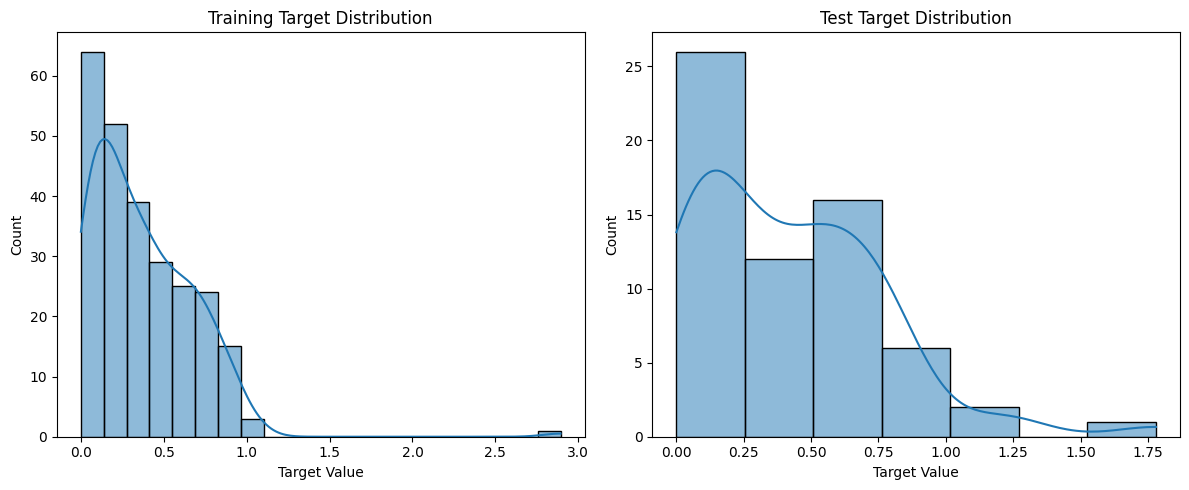


Tuning Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters for Linear Regression:
{}
Train R² Score: 0.8118
Test R² Score: 0.8722
Train RMSE: 0.1382
Test RMSE: 0.1250


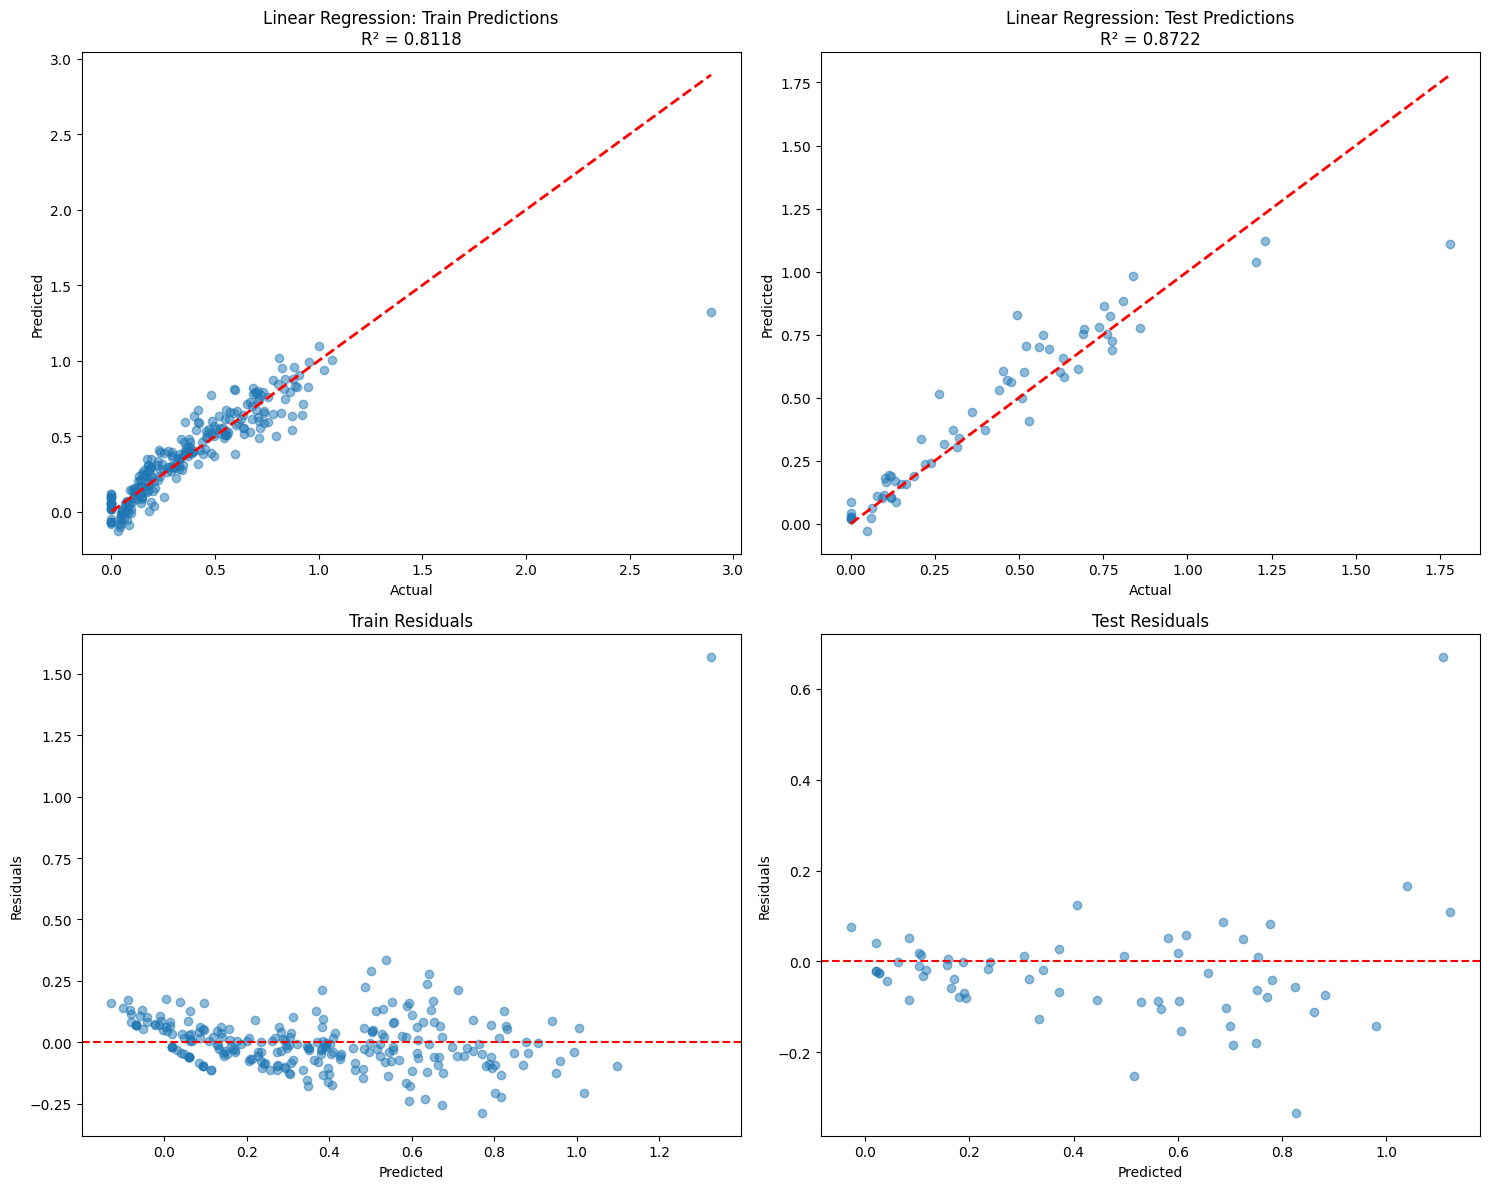


Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Train R² Score: 0.9696
Test R² Score: 0.8534
Train RMSE: 0.0556
Test RMSE: 0.1339


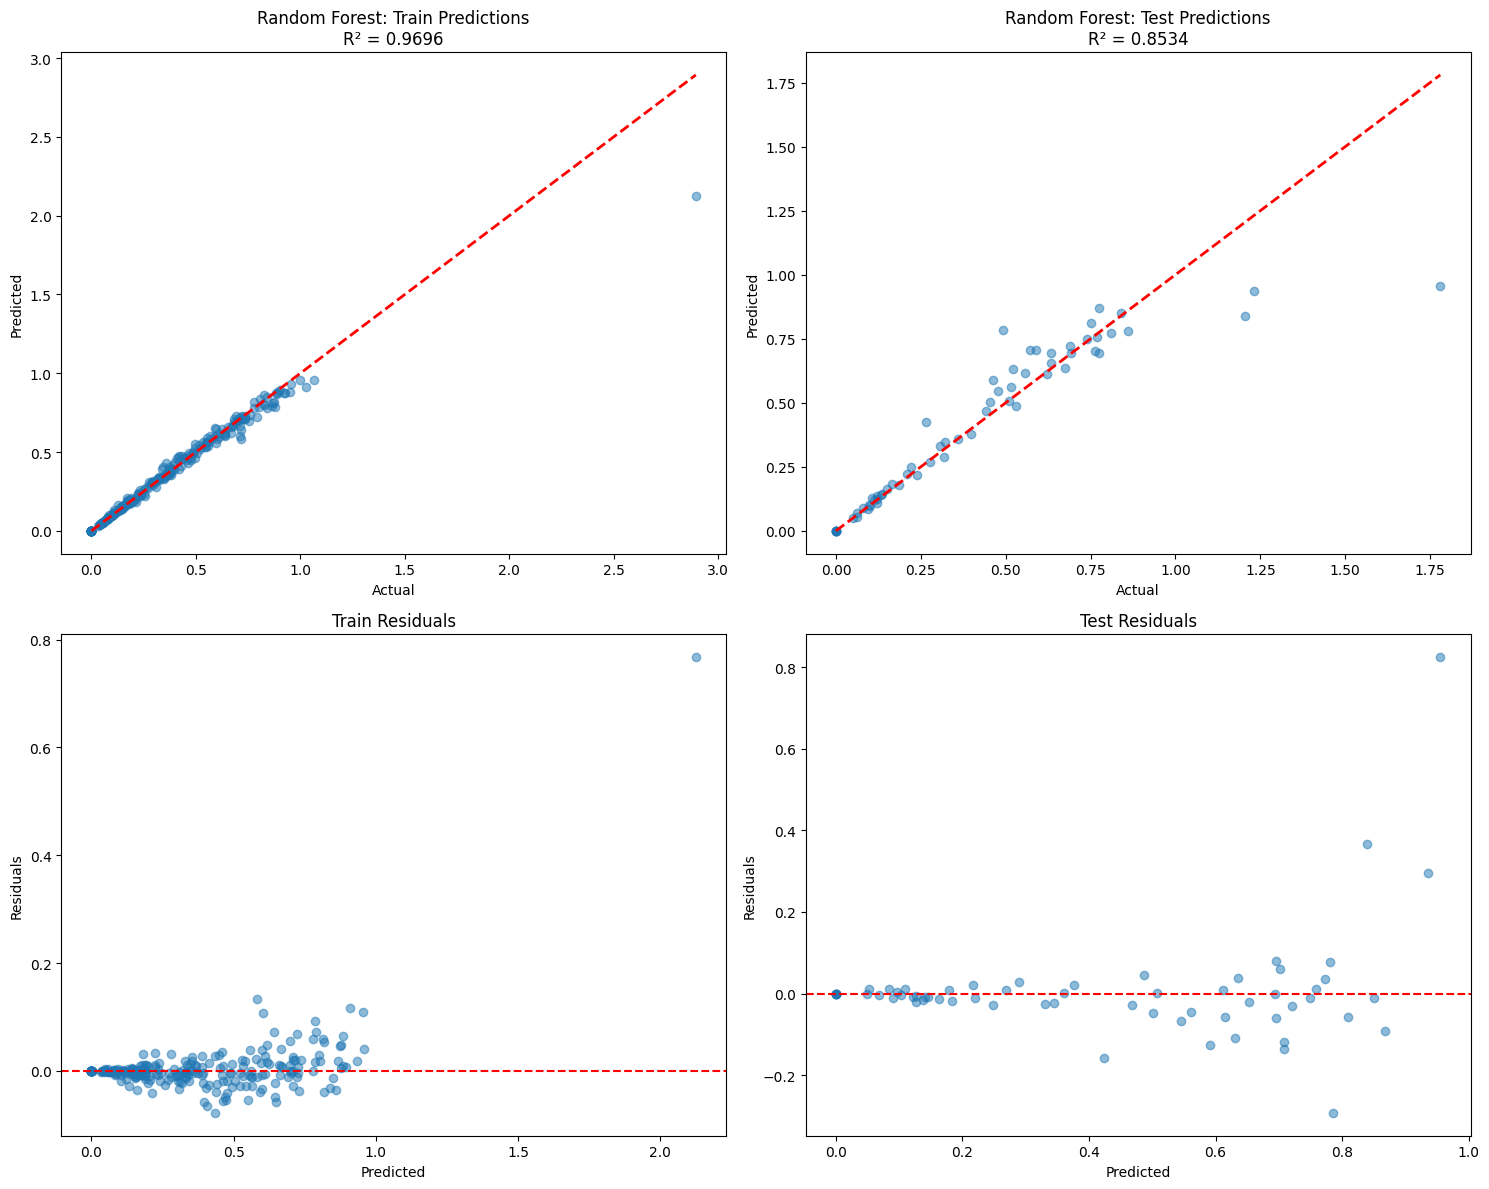

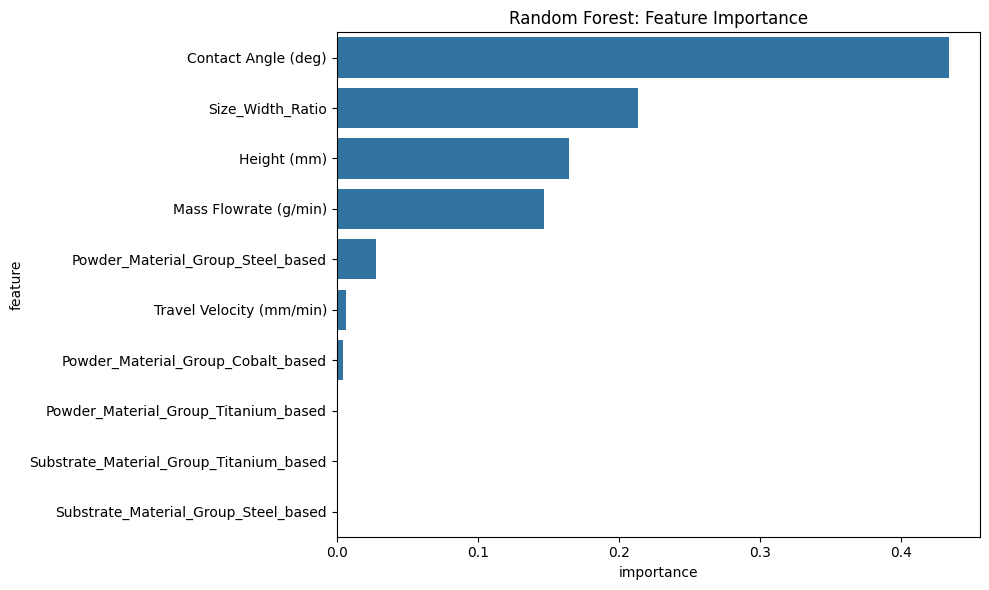


Tuning AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\Pratik\anaconda3\envs\ras598\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best parameters for AdaBoost:
{'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 100}
Train R² Score: 0.9291
Test R² Score: 0.7904
Train RMSE: 0.0848
Test RMSE: 0.1601


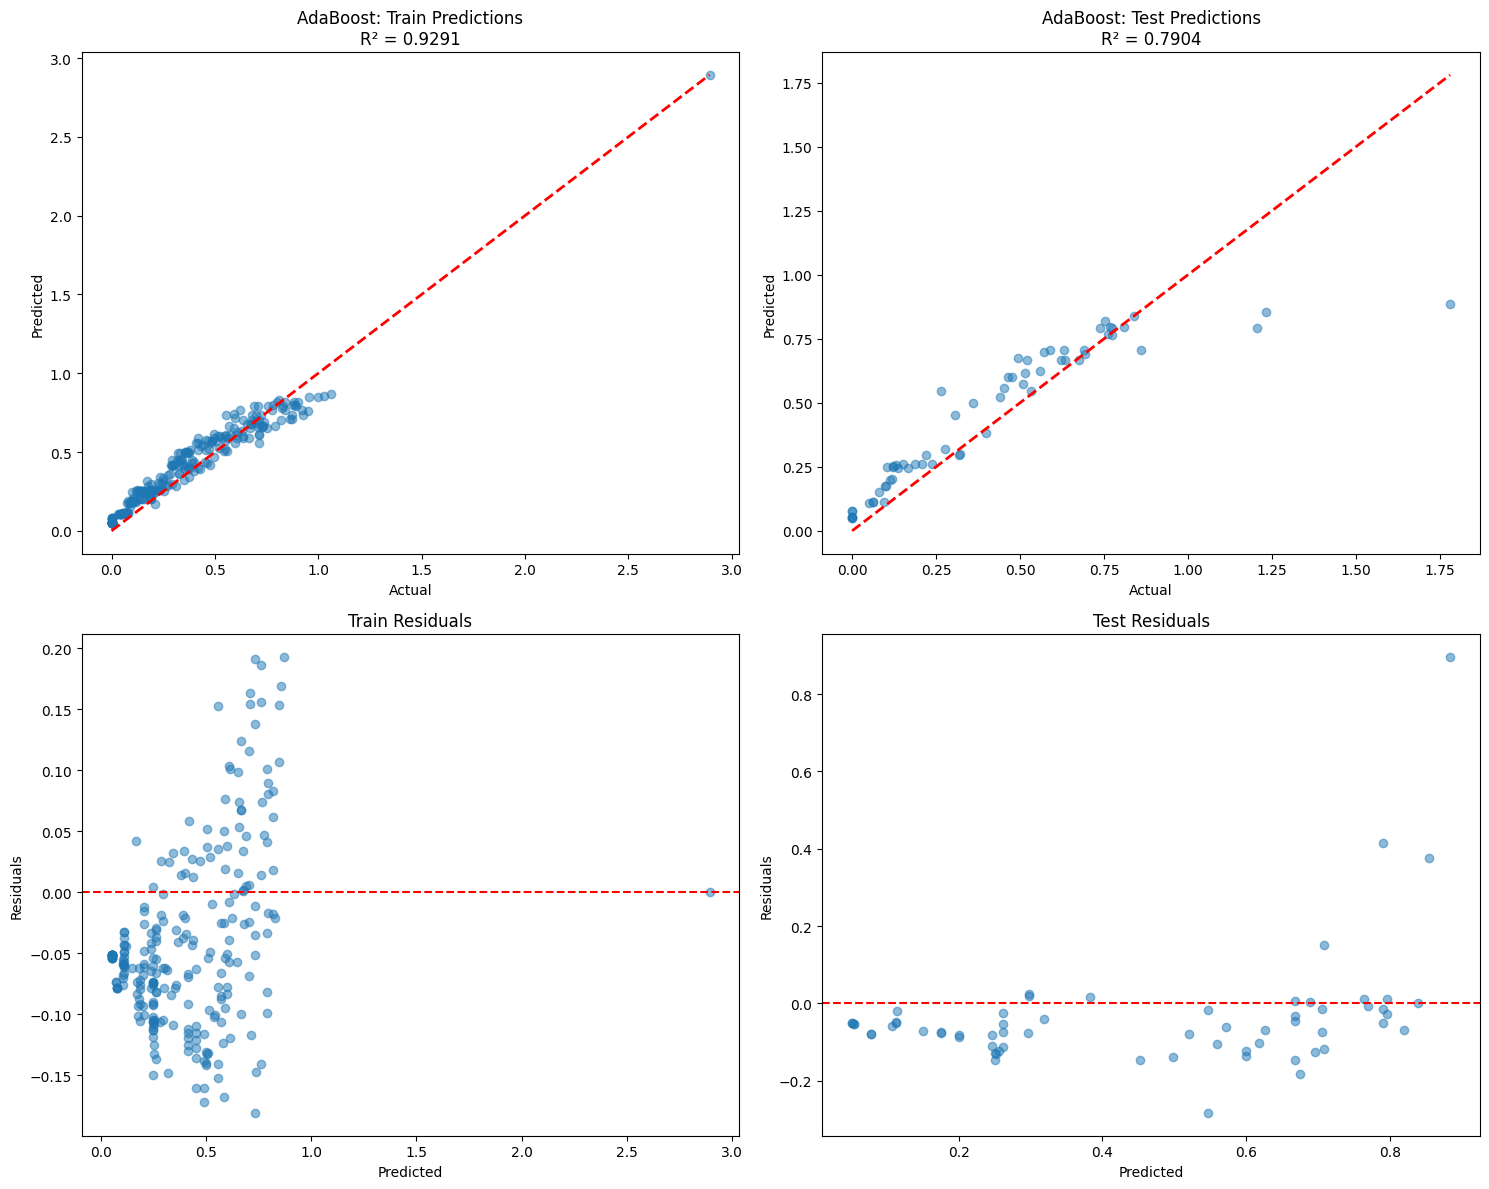


Tuning XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters for XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Train R² Score: 0.9152
Test R² Score: 0.8284
Train RMSE: 0.0928
Test RMSE: 0.1449


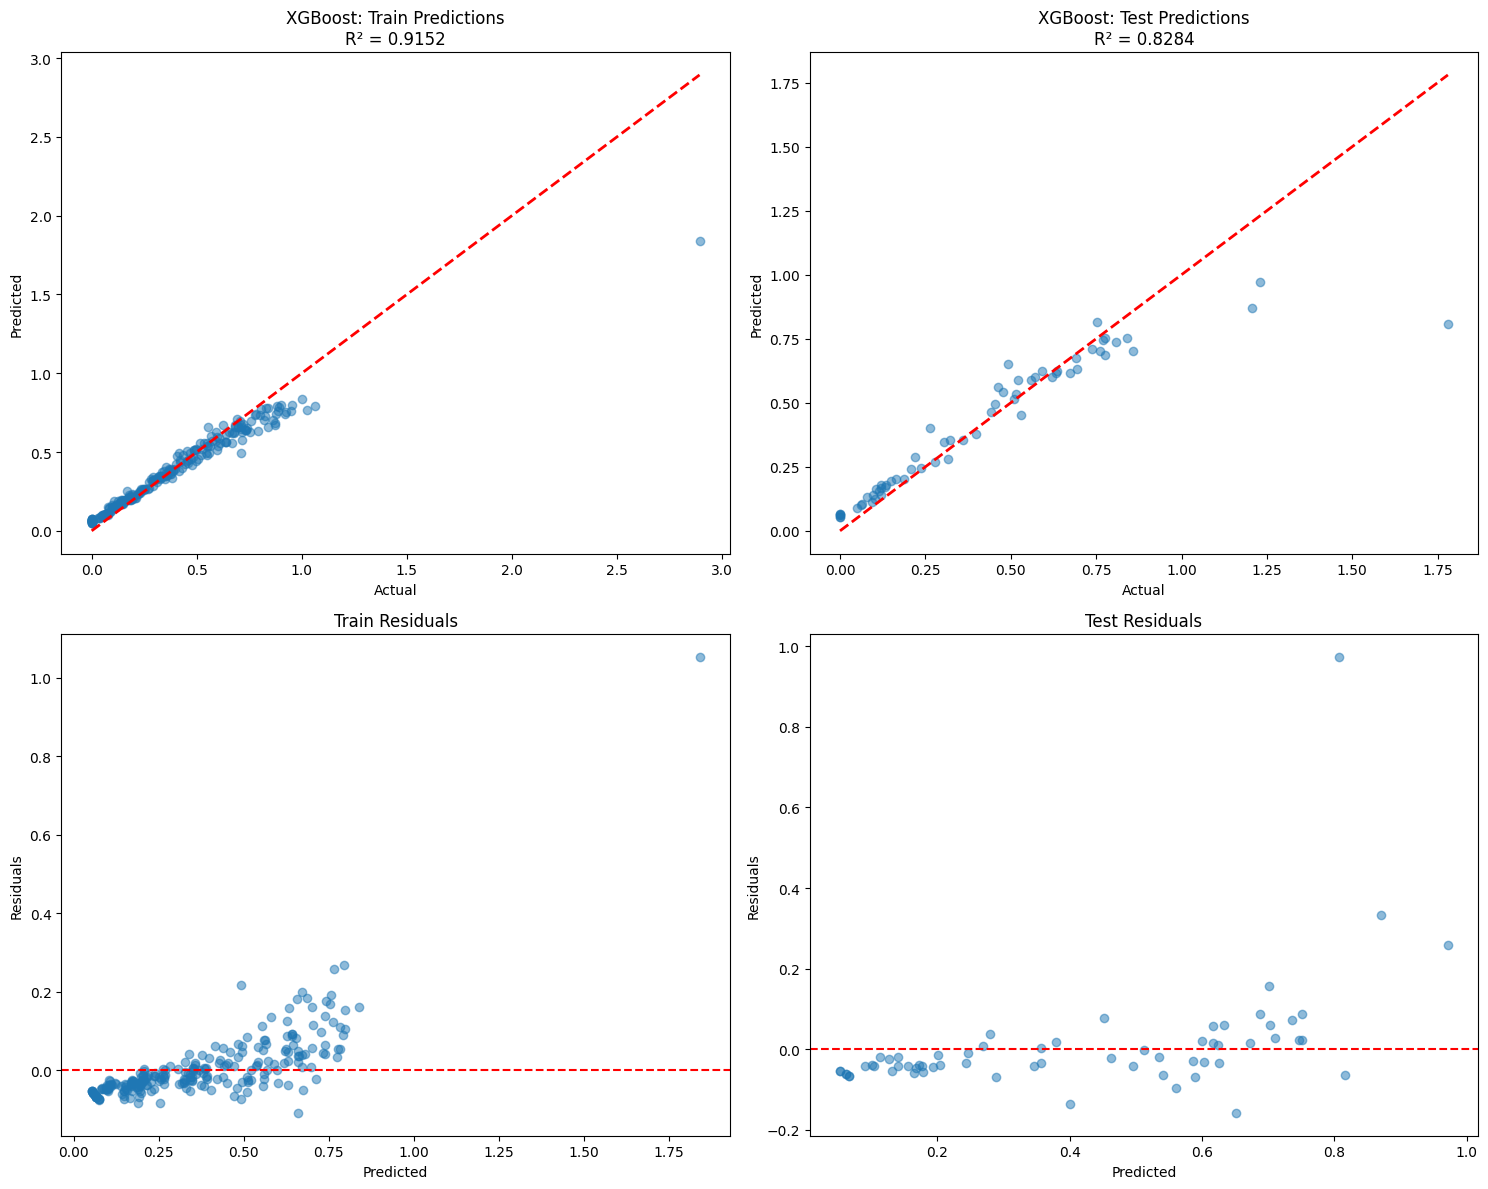

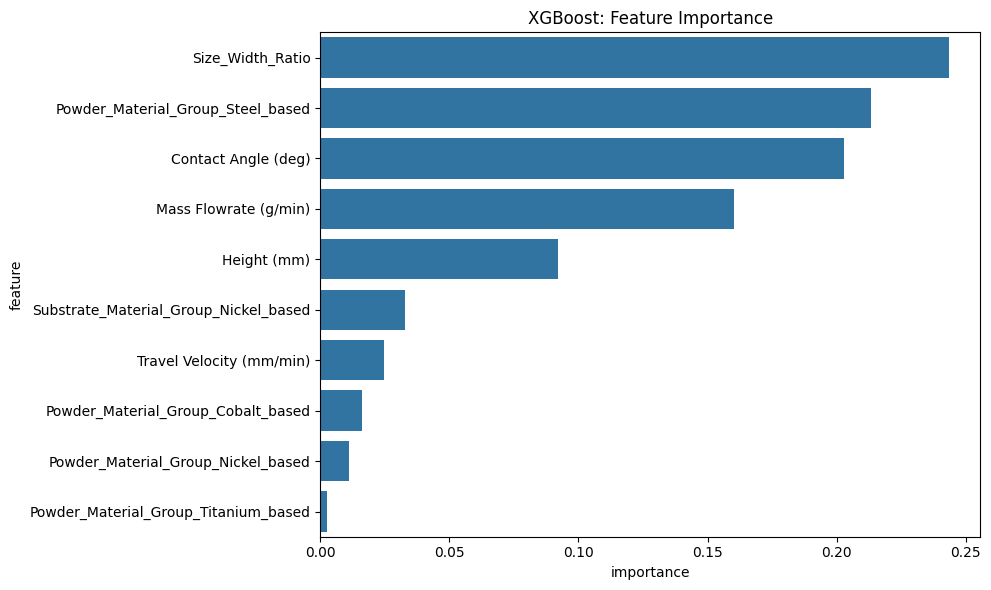


Model Comparison:
                   Train R²   Test R²  Train RMSE  Test RMSE
Linear Regression  0.811782  0.872214    0.138179   0.125038
Random Forest      0.969558  0.853367    0.055571   0.133942
AdaBoost           0.929074  0.790388    0.084823   0.160144
XGBoost            0.915169  0.828373    0.092766   0.144909


<Figure size 1200x600 with 0 Axes>

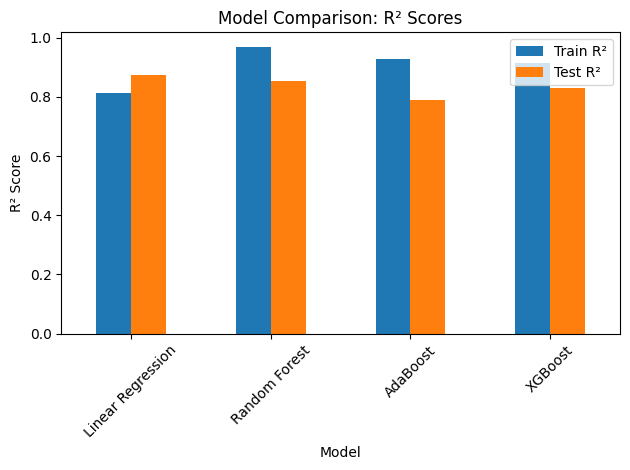

In [39]:
results, model_comparison = train_tune_evaluate_models(
    X_train, X_test, 
    y_train, y_test, 
    cv=5
)